# Download Finance Data and Make Simple Calculation

In [ ]:
# Install Dependencies
%pip install -r requirements.txt

In [26]:
# Imports
import numpy as np
import pandas as pd

import time
from datetime import date

#Data visualization
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt

#Fin Data Sources
import pandas_datareader as pdr

# Yahoo finance
import yfinance as yf


### Question 1: [Macro] Average growth of GDP in 2023

What is the average growth (in %) of GDP in 2023?

Download the timeseries Real Gross Domestic Product (GDPC1) from FRED (https://fred.stlouisfed.org/series/GDPC1). Calculate year-over-year (YoY) growth rate (that is, divide current value to one 4 quarters ago). Find the average YoY growth in 2023 (average from 4 YoY numbers). Round to 1 digit after the decimal point: e.g. if you get 5.66% growth => you should answer 5.7

In [4]:
# Define FRED code for GDPC1
fred_code = "GDPC1"

# Download GDPC1 data start at 2010
# For calculating YoY growth, you need at least 4 data points (current and 4 quarters back)
gdp_data = pdr.DataReader(fred_code, "fred", start="2010-01-01", end="2024-04-18")

# Convert index to datetime (optional, pandas_datareader usually handles this)
# gdp_data.index = pd.to_datetime(gdp_data.index)

# Calculate YoY growth rate between the current GDP value and the GDP value from 4 quarters ago (YoY).
yoy_growth = (gdp_data / gdp_data.shift(4) - 1) * 100

# Filter data for 2023 and calculate average YoY growth
yoy_growth_2023 = yoy_growth[yoy_growth.index.year == 2023]
average_growth_2023 = round(yoy_growth_2023.mean(), 1)

# Print the average YoY growth in 2023
print(f"Average YoY Growth Rate (2023): {average_growth_2023}%")


Average YoY Growth Rate (2023): GDPC1    2.5
dtype: float64%


### Question 2. [Macro] Inverse "Treasury Yield"
Find the min value of (dgs10-dgs2) after since year 2000 (2000-01-01) and write it down as an answer, round to 1 digit after the decimal point.

Download DGS2 and DGS10 interest rates series (https://fred.stlouisfed.org/series/DGS2, https://fred.stlouisfed.org/series/DGS10). Join them together to one dataframe on date (you might need to read about pandas.DataFrame.join()), calculate the difference dgs10-dgs2 daily.

(Additional: think about what does the "inverted yield curve" mean for the market and investors? do you see the same thing in your country/market of interest? Do you think it can be a good predictive feature for the models?)

In [5]:
# Define FRED codes for DGS2 and DGS10
dgs2_code = "DGS2"
dgs10_code = "DGS10"

# Download data from FRED 
start_date = "2000-01-01"
end_date = "2024-04-18"  # Adjust end date as needed
dgs2_data = pdr.DataReader(dgs2_code,"fred", start=start_date, end=end_date)
dgs10_data = pdr.DataReader(dgs10_code,"fred", start=start_date, end=end_date)

# Join dataframes on date (assuming daily data)
joined_data = pd.DataFrame.join(dgs2_data, dgs10_data)
joined_data.dropna(inplace=True)  # Handle missing values

# Calculate spread (DGS10 - DGS2)
spread = joined_data[dgs10_code] - joined_data[dgs2_code]

# Find minimum spread after year 2000
min_spread_after_2000 = round(spread[spread.index.year > 2000].min(), 1)

# Print the minimum spread
print(f"Minimum value of (DGS10-DGS2) after 2000-01-01: {min_spread_after_2000}")



Minimum value of (DGS10-DGS2) after 2000-01-01: -1.1


**Inverted Yield Curve Discussion**

An inverted yield curve occurs when short-term interest rates (like DGS2) are higher than long-term rates (like DGS10). This is typically seen as a signal of a potential economic slowdown or recession. The rationale is that investors might demand a higher premium for holding long-term debt during uncertain economic times.

**Additional Considerations:**

-  **Market-Specific Analysis:**  The interpretation of the yield curve can vary depending on the specific market and economic conditions. Analyzing the historical behavior of the yield curve in your country/market of interest would be necessary to draw meaningful conclusions.
-  **Predictive Feature:** The spread (DGS10 - DGS2) might be a potential feature for economic forecasting models. However, its effectiveness would depend on the model design, historical data, and other economic indicators considered.



### Question 3. [Index] Which Index is better recently?

Compare S&P 500 and IPC Mexico indexes by the 5 year growth and write down the largest value as an answer (%)

Download on Yahoo Finance two daily index prices for S&P 500 (^GSPC, https://finance.yahoo.com/quote/%5EGSPC/) and IPC Mexico (^MXX, https://finance.yahoo.com/quote/%5EMXX/). Compare 5Y growth for both (between 2019-04-09 and 2024-04-09). Select the higher growing index and write down the growth in % (closest integer %). E.g. if ratio end/start was 2.0925 (or growth of 109.25%), you need to write down 109 as your answer.

(Additional: think of other indexes and try to download stats and compare the growth? Do create 10Y and 20Y growth stats. What is an average yearly growth rate (CAGR) for each of the indexes you select?)


In [76]:
class StockIndexAnalyzer:

    @staticmethod
    def download_data(ticker_symbol, fields="Adj Close", start_date=None, end_date=None, interval=None):
        """Downloads stock price data for a given symbol and timeframe.

        Args:
            ticker_symbol (str): The ticker symbol of the stock index.
            fields (str, optional): The data fields to download (default: "Adj Close").
            start_date (str, optional): The starting date for data download (default: None, downloads entire history).
            end_date (str, optional): The ending date for data download (default: None, downloads until today).

        Returns:
            pandas.DataFrame: The downloaded stock price data.
        """

        data = yf.download(ticker_symbol, start=start_date, end=end_date, interval=interval)[fields]
        return data

    @staticmethod
    def calc_growth_rates(data):
        """Calculates growth rates for a given time delta.

        Args:
            data (pandas.DataFrame): The stock price data.
            time_delta (pandas.Timedelta): The time delta for growth rate calculation.

        Returns:
            pandas.Series: A Series containing growth rates for each date in the data.
        """        
        growth_rates = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
        return growth_rates # Remove rows with NaN due to shifting

    @staticmethod
    def max_growth(growth_rate1, growth_rate2):
        """Compares two growth rates and returns the maximum one.

        Args:
            growth_rate1 (float): The first growth rate.
            growth_rate2 (float): The second growth rate.

        Returns:
            float: The maximum growth rate.
        """

        return round(max(growth_rate1, growth_rate2))

    @staticmethod
    def estimate_cagr(data):
        """Estimates the Compound Annual Growth Rate (CAGR) for a given time delta.

        Args:
            data (pandas.DataFrame): The stock price data.
            time_delta (pandas.Timedelta): The time delta for CAGR calculation.

        Returns:
            float: The estimated CAGR as a percentage.
        """

        # Assuming constant growth for simplicity (more accurate methods exist)
        # latest_date = data.index[-1]  # Get the latest date from the index
        n_periods = len(data) / 365  # Approximate number of periods (assuming daily data)        
        cagr_est = ((data.iloc[-1] / data.iloc[0])**(1/n_periods) - 1) * 100
        return cagr_est 
     
    @staticmethod 
    def calculate_range_ratio(data):
        """Calculates the 52-week range ratio for a given stock's data.

        Args:
            data (pandas.DataFrame): The OHLCV data for the stock.

        Returns:
            float: The 52-week range ratio rounded to two decimal places.
        """

        if data.empty:
            return None  # Handle case where data download fails
        
        # Calculate maximum and minimum Adj. Close prices
        max_price = data.max()
        min_price = data.min()

        # Calculate and round the range ratio
        if max_price > 0:  # Avoid division by zero
            range_ratio = (max_price - min_price) / max_price
        else:
            range_ratio = 0

        return round(range_ratio, 2)
    
    @staticmethod
    def calculate_dividend_yield(ticker, start, end):
        """Calculates the dividend yield for a given stock in 2023.

        Args:
            ticker (str): The stock ticker symbol.

        Returns:
            float: The dividend yield in percentage (rounded to one decimal place) or None if data is unavailable.
        """

        try:
            # Download stock data (including dividends)
            data = yf.download(ticker, start, end, actions=True)

            # Extract dividends for 2023
            dividends_2023 = data["Dividends"].sum()

            # Get the closing price on the last trading day of 2023 (assuming 'Adj Close' exists)
            closing_price = data["Adj Close"].iloc[-1]

            # Calculate and round the dividend yield (avoid division by zero)
            if closing_price > 0:
                dividend_yield = (dividends_2023 / closing_price) * 100
                return round(dividend_yield, 1)
            else:
                return None

        except (yf.DownloadError, KeyError):
            # Handle potential download errors or missing data
            return None
    
    @staticmethod
    def get_financial_data(ticker):
        """Gets the financial data

        Args:
            ticker (str): The stock ticker symbol.

        Returns:
            pandas.Series: with finacial rows and date columns for the last few years 
            Shape (43,4)
            	                        2024-01-31	        2023-01-31	    2022-01-31	    2021-01-31
            Tax Effect Of Unusual Items	    0.0	           -284130000.0	        0.0	            0.0
            Tax Rate For Calcs	            0.12	        0.21	            0.019	        0.017
            Normalized EBITDA	            35583000000.0	7340000000.0	11351000000.0	5691000000.0
                        
            data.financials.get('2023-01-31')["Basic EPS"]
            data.financials.loc["Basic EPS","2023-01-31"]

        """

        try:
            # Download historical data (including financials)
            data =  yf.Ticker(ticker)
            return data.financials
            
        except (yf.DownloadError, KeyError):
            # Handle potential download errors or missing data
            return None


In [11]:
# Define start and end dates for 5Y growth calculation
start_date = "2019-04-09"
end_date = "2024-04-09"  # Adjust end date if needed

sp500_data = StockIndexAnalyzer.download_data(ticker_symbol="^GSPC", start_date=start_date, end_date=end_date)
ipc_data = StockIndexAnalyzer.download_data(ticker_symbol="^MXX", start_date=start_date, end_date=end_date)

# the data is already filter, use timedelta = 0
sp500_growth = StockIndexAnalyzer.calc_growth_rates(sp500_data)
ipc_growth = StockIndexAnalyzer.calc_growth_rates(ipc_data)

print(f' sp500: {sp500_growth} ipc: {ipc_growth}')
# Find the index with the highest growth (rounded to nearest integer %)
highest_growth = StockIndexAnalyzer.max_growth(sp500_growth, ipc_growth)

# Print the index with the highest 5-year growth
print(f"Highest 5-year growth: {highest_growth}%")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

 sp500: 80.75151917783086 ipc: 28.43377484045295
Highest 5-year growth: 81%


In [15]:
closing = yf.download("AAPL")["Close"]
today = closing.index[-1].date()  # Get the most recent closing date

# Define start and end dates for different timeframes
ten_years_ago = today - pd.Timedelta(days=365 * 10)
twenty_years_ago = today - pd.Timedelta(days=365 * 20)

print(today, ten_years_ago, twenty_years_ago)

[*********************100%%**********************]  1 of 1 completed

2024-04-22 2014-04-25 2004-04-27


In [16]:
# Download data for each index
sp500 = StockIndexAnalyzer.download_data(ticker_symbol="^GSPC", start_date=ten_years_ago, end_date=end_date)
nasdaq = StockIndexAnalyzer.download_data(ticker_symbol="^IXIC", start_date=ten_years_ago, end_date=end_date)
dow_jones = StockIndexAnalyzer.download_data(ticker_symbol="^DJI", start_date=ten_years_ago, end_date=end_date)

# download 20 yrs
sp500_20 = StockIndexAnalyzer.download_data(ticker_symbol="^GSPC", start_date=twenty_years_ago, end_date=end_date)
nasdaq_20 = StockIndexAnalyzer.download_data(ticker_symbol="^IXIC", start_date=twenty_years_ago, end_date=end_date)
dow_jones_20 = StockIndexAnalyzer.download_data(ticker_symbol="^DJI", start_date=twenty_years_ago, end_date=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [17]:

# Calculate 10-year and 20-year growth rates 
sp500_growth_10y =  StockIndexAnalyzer.calc_growth_rates(sp500) 
sp500_growth_20y = StockIndexAnalyzer.calc_growth_rates(sp500_20) 

nasdaq_growth_10y = StockIndexAnalyzer.calc_growth_rates(nasdaq) 
nasdaq_growth_20y = StockIndexAnalyzer.calc_growth_rates(nasdaq_20) 

dow_jones_growth_10y = StockIndexAnalyzer.calc_growth_rates(dow_jones) 
dow_jones_growth_20y = StockIndexAnalyzer.calc_growth_rates(dow_jones_20) 


# Estimate CAGR (assuming constant growth for simplicity)
sp500_cagr_est = StockIndexAnalyzer.estimate_cagr(sp500)
nasdaq_cagr_est = StockIndexAnalyzer.estimate_cagr(nasdaq)
dow_jones_cagr_est = StockIndexAnalyzer.estimate_cagr(dow_jones)

# Print results
print("Index Name\t10-Year Growth (%)\t20-Year Growth (%)\tEstimated CAGR (%)")
print(f"S&P 500\t\t{sp500_growth_10y:.2f}\t\t\t{sp500_growth_20y:.2f}\t\t\t{sp500_cagr_est:.2f}")
print(f"Nasdaq\t\t{nasdaq_growth_10y:.2f}\t\t\t{nasdaq_growth_20y:.2f}\t\t\t{nasdaq_cagr_est:.2f}")
print(f"Dow Jones\t{dow_jones_growth_10y:.2f}\t\t\t{dow_jones_growth_20y:.2f}\t\t\t{dow_jones_cagr_est:.2f}")


Index Name	10-Year Growth (%)	20-Year Growth (%)	Estimated CAGR (%)
S&P 500		179.19			357.11			16.14
Nasdaq		298.82			699.69			22.33
Dow Jones	137.71			271.18			13.45


Question 4. [Stocks OHLCV] 52-weeks range ratio (2023) for the selected stocks
Find the largest range ratio [=(max-min)/max] of Adj.Close prices in 2023

Download the 2023 daily OHLCV data on Yahoo Finance for top6 stocks on earnings (https://companiesmarketcap.com/most-profitable-companies/): 2222.SR,BRK-B, AAPL, MSFT, GOOG, JPM.

Here is the example data you should see in Pandas for "2222.SR": https://finance.yahoo.com/quote/2222.SR/history

Calculate maximum-minimim "Adj.Close" price for each stock and divide it by the maximum "Adj.Close" value. Round the result to two decimal places (e.g. 0.1575 will be 0.16)

(Additional: why this may be important for your research?)

In [37]:
# Top 6 stocks on earnings
tickers = ["2222.SR", "BRK-B", "AAPL", "MSFT", "GOOG", "JPM"]

start_date="2023-01-01"
end_date="2023-12-31"

# Analyze each stock's data (assuming data is available)
stock_ratios = {}
for ticker in tickers:
    # data = stock_data[ticker]  # Uncomment if using downloaded data
    data = StockIndexAnalyzer.download_data(ticker_symbol=ticker, start_date=start_date, end_date=end_date, interval="1d") 
    # print(data.info)
    ratio = StockIndexAnalyzer.calculate_range_ratio(data)
    print(f"Ticker: {ticker} ")
    stock_ratios[ticker] = ratio

# Print the results
print("Stock Ticker\t52-Week Range Ratio (2023)")
for ticker, ratio in stock_ratios.items():
    if ratio is not None:
        print(f"{ticker}\t\t{ratio}")
    else:
        print(f"{ticker}\t\tData Unavailable")



[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Ticker: 2222.SR 
Ticker: BRK-B 
Ticker: AAPL 
Ticker: MSFT 
Ticker: GOOG 
Ticker: JPM 
Stock Ticker	52-Week Range Ratio (2023)
2222.SR		0.21
BRK-B		0.21
AAPL		0.37
MSFT		0.42
GOOG		0.39
JPM		0.28


**Why is the 52-week range ratio important?**

The 52-week range ratio provides insights into a stock's price volatility within the past year. Here's how it can be valuable:

- Volatility Indicator: A high ratio (closer to 1) suggests a larger price swing (more volatile). Conversely, a low ratio indicates a narrower price range (potentially less volatile). This can help assess the stock's risk profile.
- Potential Trading Opportunities: Investors might use the range

**Volatility:**
- **AMD (0.58)**: This has the highest ratio, indicating the largest price swing (most volatile) within the past year (2023) among the listed stocks.
- **MSFT (0.42**): This also has a relatively high ratio, suggesting significant price movement in 2023.
- **AAPL (0.37), GOOG (0.39), JPM (0.28)**: These stocks have moderate volatility based on their ratios.
- **2222.SR & BRK-B (0.21)**: These have the lowest ratios, suggesting a tighter price range and potentially lower volatility in 2023.

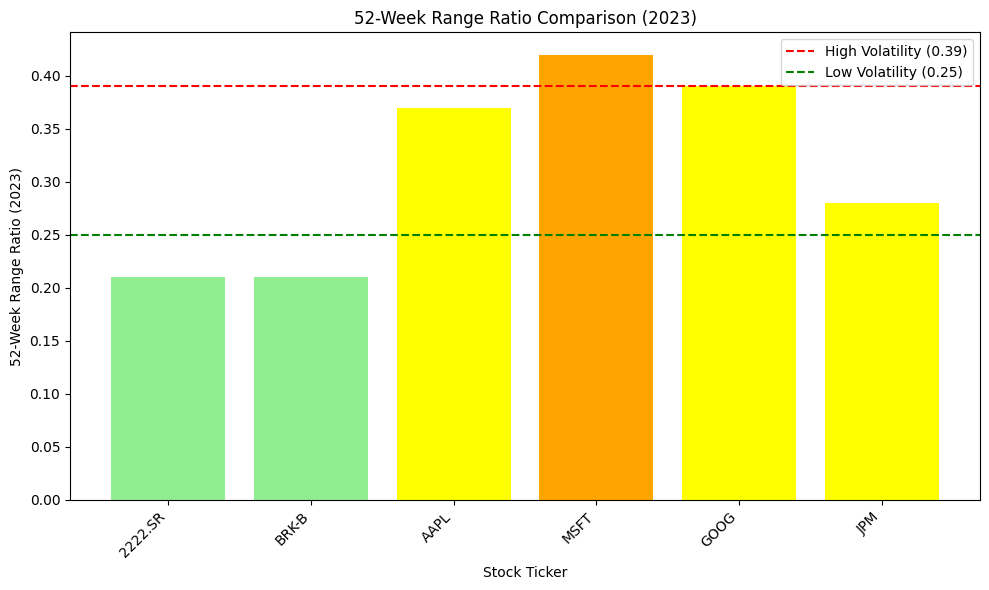

In [38]:
# Stock tickers and their corresponding ratios (replace with your actual data)
tickers = stock_ratios.keys()
ratios = stock_ratios.values()  # Replace with your calculated ratios

# Threshold for coloring
high = 0.39
low = 0.25

# Create colors based on thresholds
colors = ['lightgreen' if ratio < low else ('yellow' if ratio <= high else 'orange') for ratio in ratios]

# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(tickers, ratios, color=colors)
plt.xlabel("Stock Ticker")
plt.ylabel("52-Week Range Ratio (2023)")
plt.title("52-Week Range Ratio Comparison (2023)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Add a dotted line for the thresholds high/low
plt.axhline(y=high, color='red', linestyle='--', label=f"High Volatility ({high})")
plt.axhline(y=low, color='green', linestyle='--', label=f"Low Volatility ({low})")
plt.legend()  # Include legend for the threshold line

plt.tight_layout()

# Display the chart
plt.show()

Question 5. [Stocks] Dividend Yield
Find the largest dividend yield for the same set of stocks

Use the same list of companies (2222.SR,BRK-B, AAPL, MSFT, GOOG, JPM) and download all dividends paid in 2023. You can use get_actions() method or .dividends field in yfinance library (https://github.com/ranaroussi/yfinance?tab=readme-ov-file#quick-start)

Sum up all dividends paid in 2023 per company and divide each value by the closing price (Adj.Close) at the last trading day of the year.

Find the maximm value in % and round to 1 digit after the decimal point. (E.g., if you obtained $1.25 dividends paid and the end year stock price is $100, the dividend yield is 1.25% -- and your answer should be equal to 1.3)

In [98]:
# Calculate dividend yield for each stock
dividend_yields = {}
for ticker in tickers:
    yield_value = StockIndexAnalyzer.calculate_dividend_yield(ticker, start_date, end_date)
    print(f"{ticker} dividend {yield_value}")
    dividend_yields[ticker] = yield_value

# Find the stock with the maximum dividend yield
max_yield_ticker = None
max_yield = 0
for ticker, yield_value in dividend_yields.items():
    if yield_value is not None and yield_value > max_yield:
        max_yield = yield_value
        max_yield_ticker = ticker

# Print the results
if max_yield_ticker:
    print(f"Stock with Highest Dividend Yield (2023): {max_yield_ticker} - {max_yield:.1f}%")
else:
    print("Dividend yield data unavailable for all stocks.")


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

2222.SR dividend 2.8
BRK-B dividend 0.0
AAPL dividend 0.5
MSFT dividend 0.7
GOOG dividend 0.0
JPM dividend 2.4
Stock with Highest Dividend Yield (2023): 2222.SR - 2.8%


Question 6. [Exploratory] Investigate new metrics
Free text answer

Download and explore a few additional metrics or time series that might be valuable for your project and write down why (briefly).

> **Earnings Per Share (EPS):** This metric shows a company's profit attributable to each common share outstanding. It helps assess a company's profitability and its ability to maintain dividend payments in the future.


In [97]:
# Calculate average EPS for each stock
eps_values = {}
for ticker in tickers:
    data =  yf.Ticker(ticker)
    eps = data.financials.loc["Basic EPS",data.financials.columns[1]]    
    print(f" {ticker} {eps}")
    # eps_values[ticker] = eps


 2222.SR 2.47
 BRK-B -10.329338
 AAPL 6.15
 MSFT 9.7
 GOOG 4.59
 JPM 12.1


Question 7. [Exploratory] Time-driven strategy description around earnings releases
Free text answer

Explore earning dates for the whole month of April - e.g. using YahooFinance earnings calendar (https://finance.yahoo.com/calendar/earnings?from=2024-04-21&to=2024-04-27&day=2024-04-23). Compare with the previous closed earnings (e.g., recent dates with full data https://finance.yahoo.com/calendar/earnings?from=2024-04-07&to=2024-04-13&day=2024-04-08).

Describe an analytical strategy/idea (you're not required to implement it) to select a subset companies of interest based on the future events data.

My strategy is focused on established companies with stable performance and dividends. 2222.SR seems to provide the better dividend yield, has low volatility and an EPS of .45

In [100]:
import requests
from bs4 import BeautifulSoup

# Define URL formats for future and past earnings
future_url_format = "https://finance.yahoo.com/calendar/earnings?from={start_date}&to={end_date}&day={day}"
past_url_format = "https://finance.yahoo.com/calendar/earnings?from={start_date}&to={end_date}&day={day}"

# Define timeframes for April (adjust as needed)
future_start_date = "2024-04-01"
future_end_date = "2024-04-30"
past_start_date = "2024-04-01"
past_end_date = "2024-04-20"

# Function to scrape earnings data from a URL
def scrape_earnings_data(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")

  # Find the download link within the webpage
  download_link = soup.find("a", {"rel": "nofollow", "href": "?download=csv"})

  # Extract relevant data from the table (adjust selectors as needed)
  table = soup.find("table", class_="W(100%)") 
  if table:
    rows = table.find_all("tr", class_="simpTblRow")
    data = []
    for row in rows:
      cells = row.find_all("td")
      if cells:
        ticker = cells[0].text.strip()
        company_name = cells[1].text.strip()
        earnings_date = cells[2].text.strip()
        # Add analyst estimates or other data if available from cells
        data.append({"Ticker": ticker, "Company": company_name, "Earnings Date": earnings_date})
    return pd.DataFrame(data)
  else:
    print(f"Error: Table not found in URL: {url}")
    return None

# Scrape future and past earnings data
future_data = scrape_earnings_data(future_url_format.format(start_date=future_start_date, end_date=future_end_date, day="any"))
past_data = scrape_earnings_data(past_url_format.format(start_date=past_start_date, end_date=past_end_date, day="any"))

# Print or analyze the dataframes
if future_data is not None:
  print("Future Earnings (April):")
  print(future_data)

if past_data is not None:
  print("Past Earnings (April):")
  print(past_data)

# Further analysis can be done by comparing dataframes or applying selection criteria
# as described in the previous response.


Future Earnings (April):
   Ticker                            Company  \
0    INLB                   Item 9 Labs Corp   
1    INLB                   Item 9 Labs Corp   
2    ABIO                 ARCA Biopharma Inc   
3    AMNF  Armanino Foods Of Distinction Inc   
4   ATCMF                  Atico Mining Corp   
..    ...                                ...   
95  BBRRF           Blueberries Medical Corp   
96   BSRR                     Sierra Bancorp   
97   IBTX         Independent Bank Group Inc   
98  BIOCQ                        Biocept Inc   
99   TRST              TrustCo Bank Corp N Y   

                                    Earnings Date  
0                       Q4 2023  Earnings Release  
1                       Q1 2024  Earnings Release  
2                       Q1 2024  Earnings Release  
3                       Q1 2024  Earnings Release  
4                       Q1 2024  Earnings Release  
..                                            ...  
95                      Q4 2023  E